In [43]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

# Configure pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

def parse_experiment_file(file_content):
    """Parse experiment log file and extract instances with explanations."""
    instances = file_content.split("INFO ENTRY:")[1:]  # Skip header
    parsed_data = []
    
    for instance in instances:
        # Extract instance details including entry name (e.g., Name: 19411)
        instance_match = re.search(
            r"Explaining instance:\s*(.*?)Name:\s*(\d+), dtype: object original_outcome: (.*?), predicted_outcome (.*?)$",
            instance, re.DOTALL | re.MULTILINE
        )
        if not instance_match:
            continue
            
        instance_text = instance_match.group(1).strip()
        entry_name = instance_match.group(2).strip()
        original_outcome = instance_match.group(3).strip()
        predicted_outcome = instance_match.group(4).strip()
        
        # Parse instance features
        instance_features = {}
        for line in instance_text.split('\n'):
            line = line.strip()
            if line and not line.startswith('Name:'):
                parts = re.split(r'\s{2,}', line, maxsplit=1)
                if len(parts) == 2:
                    instance_features[parts[0].strip()] = parts[1].strip()
        
        # Find all rule patterns
        rules = {explainer: [] for explainer in ['ANCHOR', 'LORE', 'LORE_SA', 'EXPLAN']}
        rule_pattern = r"INFO RULE: (.*?): (.*?)(?=INFO RULE:|INFO ENTRY:|$)"
        
        for rule_match in re.finditer(rule_pattern, instance, re.DOTALL):
            explainer_type = rule_match.group(1).strip()
            rule_text = rule_match.group(2).strip()
            
            if explainer_type not in rules:
                continue
            
            # Extract metrics
            metrics_match = re.search(r"Cov,Cov_class,Cov_temp ([\d\.]+); ([\d\.]+); ([\d\.]+), Pre, Len ([\d\.]+),([\d]+)", rule_text)
            
            rule_data = {'text': rule_text, 'precision': None, 'coverage': None, 
                         'coverage_class': None, 'coverage_temp': None, 'length': None}
            
            if metrics_match:
                rule_data.update({
                    'coverage': float(metrics_match.group(1)),
                    'coverage_class': float(metrics_match.group(2)),
                    'coverage_temp': float(metrics_match.group(3)),
                    'precision': float(metrics_match.group(4)),
                    'length': int(metrics_match.group(5))
                })
                
                # Clean up rule text
                rule_data['text'] = re.sub(r"Cov,Cov_class,Cov_temp [\d\.]+; [\d\.]+; [\d\.]+, Pre, Len [\d\.]+,[\d]+", "", rule_text).strip()
            
            rules[explainer_type].append(rule_data)
        
        parsed_data.append({
            'features': instance_features,
            'entry_name': entry_name,
            'original_outcome': original_outcome,
            'predicted_outcome': predicted_outcome,
            'rules': rules
        })
    
    return parsed_data

def extract_model_info(file_content):
    """Extract model performance information from file header."""
    header = file_content.split("INFO ENTRY:")[0]
    
    info = {
        'model_type': None, 'train_accuracy': None, 'test_accuracy': None,
        'train_report': None, 'test_report': None, 'target_distribution': {},
        'feature_info': {}, 'parameters': {}
    }
    
    # Extract classifier info
    classifier_match = re.search(r"Classifier: (.*?) Parameters: (.*?)$", header, re.MULTILINE)
    if classifier_match:
        info['model_type'] = classifier_match.group(1).strip()
        
        # Parse parameters
        params_match = re.search(r'{(.*?)}', classifier_match.group(2).strip())
        if params_match:
            for item in params_match.group(1).split(','):
                if ':' in item:
                    k, v = item.split(':', 1)
                    info['parameters'][k.strip().strip("'")] = v.strip()
    
    # Extract accuracy metrics
    train_acc_match = re.search(r"Train accuracy: ([\d\.]+)", header)
    test_acc_match = re.search(r"Test accuracy: ([\d\.]+)", header)
    
    if train_acc_match: info['train_accuracy'] = float(train_acc_match.group(1))
    if test_acc_match: info['test_accuracy'] = float(test_acc_match.group(1))
    
    # Extract classification reports
    train_report_match = re.search(r"Classification Report \(Train\):(.*?)(?=INFO|\Z)", header, re.DOTALL)
    test_report_match = re.search(r"Classification Report \(Test\):(.*?)(?=INFO|\Z)", header, re.DOTALL)
    
    if train_report_match: info['train_report'] = train_report_match.group(1).strip()
    if test_report_match: info['test_report'] = test_report_match.group(1).strip()
    
    # Extract target distribution
    train_dist_match = re.search(r"Train class distribution:(.*?)(?=INFO|\Z)", header, re.DOTALL)
    test_dist_match = re.search(r"Test class distribution:(.*?)(?=INFO|\Z)", header, re.DOTALL)
    
    if train_dist_match: info['target_distribution']['train'] = train_dist_match.group(1).strip()
    if test_dist_match: info['target_distribution']['test'] = test_dist_match.group(1).strip()
    
    # Extract feature information
    features_match = re.search(r"Numeric: \[(.*?)\] \n Categorical: \[(.*?)\], Continuous: \[(.*?)\]", header)
    if features_match:
        info['feature_info']['numeric'] = [f.strip().strip("'") for f in features_match.group(1).split(',')]
        info['feature_info']['categorical'] = [f.strip().strip("'") for f in features_match.group(2).split(',')]
        info['feature_info']['continuous'] = [f.strip().strip("'") for f in features_match.group(3).split(',')]
    
    return info

def display_model_info(model_info):
    """Display model performance information."""
    display(Markdown("## Model Information"))
    
    # Basic model info table
    model_table = {
        'Property': ['Model Type', 'Train Accuracy', 'Test Accuracy'] + 
                   [f"Parameter: {param}" for param in model_info['parameters']],
        'Value': [
            model_info['model_type'], 
            f"{model_info['train_accuracy']:.4f}" if model_info['train_accuracy'] is not None else 'N/A',
            f"{model_info['test_accuracy']:.4f}" if model_info['test_accuracy'] is not None else 'N/A'
        ] + list(model_info['parameters'].values())
    }
    display(pd.DataFrame(model_table))
    
    # Plot accuracy if available
    if model_info['train_accuracy'] and model_info['test_accuracy']:
        plt.figure(figsize=(8, 4))
        accuracies = [model_info['train_accuracy'], model_info['test_accuracy']]
        bars = plt.bar(['Train', 'Test'], accuracies)
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{bar.get_height():.4f}', ha='center', va='bottom')
        plt.ylim(0, 1)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.show()
    
    # Display classification reports
    for report_type in ['train_report', 'test_report']:
        if model_info[report_type]:
            display(Markdown(f"### Classification Report ({report_type.split('_')[0].title()})"))
            display(Markdown(f"```\n{model_info[report_type]}\n```"))
    
    # Display feature information
    if model_info['feature_info']:
        display(Markdown("### Feature Information"))
        feature_df = pd.DataFrame({
            'Numeric Features': pd.Series(model_info['feature_info'].get('numeric', [])),
            'Categorical Features': pd.Series(model_info['feature_info'].get('categorical', [])),
            'Continuous Features': pd.Series(model_info['feature_info'].get('continuous', []))
        })
        display(feature_df)

def display_instance_with_rules(instance, instance_idx, entry_name=None):
    """Display an instance and its associated rules."""
    display(Markdown(f"## Instance{f' - {entry_name}' if entry_name else ''}"))
    
    # Show prediction info
    outcome_info = {
        'Property': ['Original Outcome', 'Predicted Outcome', 'Prediction Status'],
        'Value': [
            instance['original_outcome'],
            instance['predicted_outcome'],
            'Correct' if instance['original_outcome'] == instance['predicted_outcome'] else 'Incorrect'
        ]
    }
    display(pd.DataFrame(outcome_info))
    
    # Display features
    features_df = pd.DataFrame(list(instance['features'].items()), columns=['Feature', 'Value']).sort_values('Feature')
    display(features_df)
    
    # Display rules and collect metrics for plotting
    display(Markdown("### Explanation Rules"))
    metric_data = {'Rule': [], 'Explainer': [], 'Cov': [], 'Cov_class': [], 'Pre': [], 'Len': []}
    combined_rules_data = []

    for explainer_type, rules in instance['rules'].items():
        if not rules:
            continue
            
        display(Markdown(f"#### {explainer_type}"))
        
        # Create rules dataframe per explainer
        rules_data = []
        for i, rule in enumerate(rules):
            rule_label = f"{explainer_type} Rule {i+1}"
            rule_info = {
                'Explainer': explainer_type,
                'Rule': rule_label,
                'Text': rule['text'],
                'Coverage (Cov)': f"{rule.get('coverage', 0):.5f}",
                'Coverage Class (Cov_class)': f"{rule.get('coverage_class', 0):.5f}",
                'Precision (Pre)': f"{rule.get('precision', 0):.5f}",
                'Length (Len)': rule.get('length', 0)
            }
            rules_data.append(rule_info)
            combined_rules_data.append(rule_info)

            # Collect metric data
            metric_data['Rule'].append(rule_label)
            metric_data['Explainer'].append(explainer_type)
            metric_data['Cov'].append(rule.get('coverage', 0))
            metric_data['Cov_class'].append(rule.get('coverage_class', 0))
            metric_data['Pre'].append(rule.get('precision', 0))
            metric_data['Len'].append(rule.get('length', 0))
        
        # Display rules table for this explainer
        with pd.option_context('display.max_colwidth', None):
            display(pd.DataFrame(rules_data))
        
        # Formatted HTML display
        display(Markdown("##### Formatted view for readability:"))
        for i, rule in enumerate(rules):
            rule_html = rule['text']
            for separator, replacement in [
                (' IF ', '<b>IF</b> '),
                (' THEN ', '<br>&nbsp;&nbsp;&nbsp;&nbsp;<b>THEN</b> '),
                (' AND ', '<br>&nbsp;&nbsp;&nbsp;&nbsp;AND ')
            ]:
                if separator in rule_html:
                    rule_html = rule_html.replace(separator, replacement)
            
            metrics = [
                f"Cov: {rule.get('coverage', 0):.5f}",
                f"Cov_class: {rule.get('coverage_class', 0):.5f}",
                f"Pre: {rule.get('precision', 0):.5f}",
                f"Len: {rule.get('length', 0)}"
            ]
            display(HTML(f"<div style='margin-left:20px;margin-bottom:10px'><b>Rule {i+1}:</b> {rule_html}<br><i>{', '.join(metrics)}</i></div>"))
    
    # Plot rule metrics
    plot_rule_metrics(metric_data, instance_idx, entry_name)

    # Display combined table for all explainers
    if combined_rules_data:
        display(Markdown("### All Rules Combined"))
        with pd.option_context('display.max_colwidth', None):
            display(pd.DataFrame(combined_rules_data))

def plot_rule_metrics(metric_data, instance_idx, entry_name=None):
    """Plot rule metrics (Cov, Cov_class, Pre) on the same plot. Append Len next to rule labels."""
    if not metric_data['Rule']:
        return
    
    plt.figure(figsize=(14, 6))
    
    bar_width = 0.25
    x = range(len(metric_data['Rule']))
    
    plt.bar([i - bar_width for i in x], metric_data['Cov'], width=bar_width, color='blue', label='Coverage')
    plt.bar(x, metric_data['Cov_class'], width=bar_width, color='green', label='Coverage Class')
    plt.bar([i + bar_width for i in x], metric_data['Pre'], width=bar_width, color='orange', label='Precision')
    
    # Add Len info to x-tick labels
    rule_labels = [
        f"{label}\n(Len: {metric_data['Len'][i]})"
        for i, label in enumerate(metric_data['Rule'])
    ]
    
    title = f"Rule Metrics for Instance {instance_idx+1}"
    if entry_name:
        title += f" - {entry_name}"
    plt.title(title)
    plt.xlabel('Rules')
    plt.ylabel('Metric Value')
    plt.xticks([i for i in x], rule_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def compare_explainers(instances):
    """Compare metrics across different explainers."""
    display(Markdown("## Explainer Comparison"))
    
    # Collect metrics for each explainer
    explainer_metrics = {
        explainer: {
            'count': 0,
            'precision': [],
            'coverage': [],
            'coverage_class': [],
            'length': []
        }
        for explainer in ['ANCHOR', 'LORE', 'LORE_SA', 'EXPLAN']
    }
    
    for instance in instances:
        for explainer, rules in instance['rules'].items():
            explainer_metrics[explainer]['count'] += len(rules)
            for rule in rules:
                if rule['precision'] is not None:
                    explainer_metrics[explainer]['precision'].append(rule['precision'])
                if rule['coverage'] is not None:
                    explainer_metrics[explainer]['coverage'].append(rule['coverage'])
                if rule['coverage_class'] is not None:
                    explainer_metrics[explainer]['coverage_class'].append(rule['coverage_class'])
                if rule['length'] is not None:
                    explainer_metrics[explainer]['length'].append(rule['length'])
    
    # Calculate averages and create comparison table
    comparison_data = []
    for explainer, metrics in explainer_metrics.items():
        if metrics['count'] > 0:
            comparison_data.append({
                'Explainer': explainer,
                'Avg Precision': sum(metrics['precision']) / len(metrics['precision']) if metrics['precision'] else 0,
                'Avg Coverage': sum(metrics['coverage']) / len(metrics['coverage']) if metrics['coverage'] else 0,
                'Avg Coverage Class': sum(metrics['coverage_class']) / len(metrics['coverage_class']) if metrics['coverage_class'] else 0,
                'Avg Length': sum(metrics['length']) / len(metrics['length']) if metrics['length'] else 0
            })
    
    # Display comparison table
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        display(df)

        # Plot metrics (excluding Rule Count)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Precision
        axes[0].bar(df['Explainer'], df['Avg Precision'])
        axes[0].set_title('Average Precision')
        axes[0].set_ylabel('Avg Precision')
        for i, v in enumerate(df['Avg Precision']):
            axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

        # Coverage and Coverage Class (side by side)
        x = np.arange(len(df['Explainer']))
        width = 0.35
        axes[1].bar(x - width/2, df['Avg Coverage'], width, label='Avg Coverage')
        axes[1].bar(x + width/2, df['Avg Coverage Class'], width, label='Avg Coverage Class')
        axes[1].set_title('Avg Coverage vs Avg Coverage Class')
        axes[1].set_ylabel('Coverage')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(df['Explainer'])
        axes[1].legend()

        # Length
        axes[2].bar(df['Explainer'], df['Avg Length'])
        axes[2].set_title('Average Rule Length')
        axes[2].set_ylabel('Avg Length')
        for i, v in enumerate(df['Avg Length']):
            axes[2].text(i, v, f'{v:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

def analyze_rule_features(instances):
    """Analyze which features are most commonly used in rules."""
    # Extract all unique features from the first instance
    all_features = set(instances[0]['features'].keys()) if instances else set()
    
    # Count feature usage by explainer
    feature_counts = {explainer: {} for explainer in ['ANCHOR', 'LORE', 'LORE_SA', 'EXPLAN']}
    
    for instance in instances:
        for explainer, rules in instance['rules'].items():
            for rule in rules:
                # Extract features used in this rule
                for feature in all_features:
                    if re.search(r'\b' + re.escape(feature) + r'\b', rule['text']):
                        feature_counts[explainer][feature] = feature_counts[explainer].get(feature, 0) + 1
    
    display(Markdown("## Feature Usage Analysis"))
    
    # Create heatmap of feature usage
    explainers = [e for e in feature_counts.keys() if feature_counts[e]]
    all_used_features = sorted(list(set().union(*[set(counts.keys()) for counts in feature_counts.values() if counts])))
    
    if not all_used_features or not explainers:
        display(Markdown("No feature usage data available"))
        return
    
    # Create heatmap data
    heatmap_data = [[feature_counts[explainer].get(feature, 0) for explainer in explainers] 
                    for feature in all_used_features]
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    plt.imshow(heatmap_data, cmap='YlOrRd')
    plt.colorbar(label='Frequency')
    plt.xticks(range(len(explainers)), explainers, rotation=45, ha='right')
    plt.yticks(range(len(all_used_features)), all_used_features)
    plt.title('Feature Usage Across Explainers')
    plt.tight_layout()
    plt.show()
    
    # Display top 5 features for each explainer
    display(Markdown("### Top Features Used by Each Explainer"))
    
    for explainer, counts in feature_counts.items():
        if not counts:
            continue
            
        # Get top 5 features
        top5 = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
        
        display(Markdown(f"#### {explainer}"))
        if top5:
            # Create DataFrame and pie chart
            display(pd.DataFrame(top5, columns=['Feature', 'Occurrence Count']))
            
            plt.figure(figsize=(8, 8))
            plt.pie([count for _, count in top5], 
                    labels=[f"{feature} ({count})" for feature, count in top5], 
                    autopct='%1.1f%%')
            plt.title(f'Top 5 Features Used by {explainer}')
            plt.tight_layout()
            plt.show()
        else:
            display(Markdown("No features used"))

def analyze_by_outcome(instances):
    """Analyze rules based on prediction outcome."""
    # Group instances by outcome
    outcomes = {}
    for instance in instances:
        outcome = instance['original_outcome']
        outcomes.setdefault(outcome, []).append(instance)
    
    display(Markdown("## Analysis by Outcome"))
    
    # Display outcome distribution
    outcome_counts = {outcome: len(insts) for outcome, insts in outcomes.items()}
    
    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(list(outcome_counts.values()), 
            labels=[f"{outcome} ({count})" for outcome, count in outcome_counts.items()], 
            autopct='%1.1f%%')
    plt.title('Instance Distribution by Outcome')
    plt.tight_layout()
    plt.show()
    
    # Analyze each outcome
    for outcome, instances_for_outcome in outcomes.items():
        display(Markdown(f"### Outcome: {outcome}"))
        
        # Collect metrics
        metrics = {
            explainer: {
                'count': 0,
                'precision': [],
                'coverage': [],
                'coverage_class': [],
                'length': []
            } 
            for explainer in ['ANCHOR', 'LORE', 'LORE_SA', 'EXPLAN']
        }
        
        for instance in instances_for_outcome:
            for explainer, rules in instance['rules'].items():
                metrics[explainer]['count'] += len(rules)
                for rule in rules:
                    if rule['precision'] is not None:
                        metrics[explainer]['precision'].append(rule['precision'])
                    if rule['coverage'] is not None:
                        metrics[explainer]['coverage'].append(rule['coverage'])
                    if rule.get('coverage_class') is not None:
                        metrics[explainer]['coverage_class'].append(rule['coverage_class'])
                    if rule['length'] is not None:
                        metrics[explainer]['length'].append(rule['length'])
        
        # Calculate average metrics
        avg_metrics = {}
        for explainer, data in metrics.items():
            avg_metrics[explainer] = {
                'Rule Count': data['count'],
                'Avg Precision': sum(data['precision']) / len(data['precision']) if data['precision'] else 0,
                'Avg Coverage': sum(data['coverage']) / len(data['coverage']) if data['coverage'] else 0,
                'Avg Coverage Class': sum(data['coverage_class']) / len(data['coverage_class']) if data['coverage_class'] else 0,
                'Avg Length': sum(data['length']) / len(data['length']) if data['length'] else 0
            }
        
        # Display metrics table
        display(pd.DataFrame.from_dict(avg_metrics, orient='index'))
        
        # Plot rule count by explainer
        plt.figure(figsize=(10, 6))
        bars = plt.bar(list(metrics.keys()), [data['count'] for data in metrics.values()])
        
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{bar.get_height()}', ha='center', va='bottom')
        
        plt.title(f'Number of Rules by Explainer for Outcome: {outcome}')
        plt.xlabel('Explainer')
        plt.ylabel('Rule Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def analyze_xai_results(file_content):
    """Main function to analyze XAI results."""
    # Parse the experiment file
    parsed_data = parse_experiment_file(file_content)
    
    if not parsed_data:
        print("No instances found in the file. Please check the format.")
        return None
    
    print(f"Found {len(parsed_data)} instances with explanations")
    
    # Extract and display model information
    model_info = extract_model_info(file_content)
    display_model_info(model_info)
    
    # Display each instance with its rules
    for i, instance in enumerate(parsed_data):
        display_instance_with_rules(instance, i+1, entry_name=instance.get('entry_name'))
    
    # Run analysis functions
    compare_explainers(parsed_data)
    analyze_rule_features(parsed_data)
    analyze_by_outcome(parsed_data)
    
    return parsed_data

In [44]:
def run_analysis_with_file(file_path):
    """Run the analysis with a specific log file."""
    
    with open(file_path, 'r') as f:
        file_content = f.read()
    
    return analyze_xai_results(file_content)

Found 4 instances with explanations


## Model Information

,Property,Value
0,Model Type,random_forest
1,Train Accuracy,0.9126
2,Test Accuracy,0.8572
3,Parameter: max_depth,20
4,Parameter: n_estimators,50
5,Parameter: random_state,42


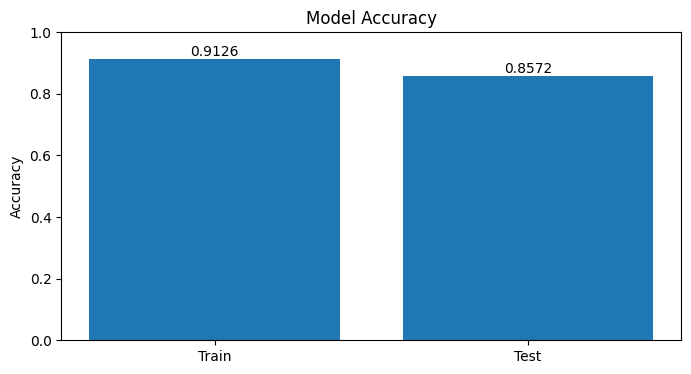

### Classification Report (Train)

```
precision    recall  f1-score   support

       <=50K       0.92      0.97      0.94     17303
        >50K       0.90      0.72      0.80      5489

    accuracy                           0.91     22792
   macro avg       0.91      0.85      0.87     22792
weighted avg       0.91      0.91      0.91     22792
```

### Classification Report (Test)

```
precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7417
        >50K       0.77      0.58      0.66      2352

    accuracy                           0.86      9769
   macro avg       0.82      0.76      0.79      9769
weighted avg       0.85      0.86      0.85      9769
```

### Feature Information

,Numeric Features,Categorical Features,Continuous Features
0,age,workclass,age
1,capital.gain,education,capital.gain
2,capital.loss,education.num,capital.loss
3,hours.per.week,marital.status,hours.per.week
4,NaN,occupation,NaN
5,NaN,relationship,NaN
6,NaN,race,NaN
7,NaN,sex,NaN
8,NaN,native.country,NaN


## Instance - 19411

,Property,Value
0,Original Outcome,<=50K
1,Predicted Outcome,<=50K
2,Prediction Status,Correct


,Feature,Value
0,age,35.0
9,capital.gain,0.0
10,capital.loss,0.0
2,education,11th
3,education.num,7
11,hours.per.week,84.0
4,marital.status,Divorced
12,native.country,United-States
5,occupation,Exec-managerial
7,race,White


### Explanation Rules

#### ANCHOR

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF age <= 37.0 AND capital.gain <= 0.0 THEN class = <=50K,0.47733,0.55831,0.88805,2
1,ANCHOR,ANCHOR Rule 2,IF capital.gain <= 0.0 AND marital.status = Divorced THEN class = <=50K,0.12417,0.14925,0.91261,2
2,ANCHOR,ANCHOR Rule 3,IF age <= 37.0 AND capital.gain <= 0.0 AND capital.loss <= 0.0 THEN class = <=50K,0.46064,0.54335,0.89556,3
3,ANCHOR,ANCHOR Rule 4,IF age <= 47.0 AND capital.gain <= 0.0 AND capital.loss <= 0.0 THEN class = <=50K,0.66220,0.72806,0.83475,3


##### Formatted view for readability:

#### LORE

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE,LORE Rule 1,IF capital.gain <= 594.0 AND sex = Female THEN class = <=50K,0.31006,0.37293,0.91317,2
1,LORE,LORE Rule 2,IF capital.gain <= 0.0 THEN class = <=50K,0.91842,0.95820,0.79213,1
2,LORE,LORE Rule 3,IF capital.gain <= 4064.0 AND sex = Female THEN class = <=50K,0.31784,0.38250,0.91369,2
3,LORE,LORE Rule 4,IF capital.gain <= 4885.808886 THEN class = <=50K,0.95035,0.99339,0.79362,1


##### Formatted view for readability:

#### LORE_SA

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE_SA,LORE_SA Rule 1,IF capital.gain <= 5975.1396484375 AND sex = Female THEN class = <=50K,0.32102,0.38533,0.91135,2
1,LORE_SA,LORE_SA Rule 2,IF age <= 35.82083320617676 AND capital.gain <= 12236.846435546875 AND education != Bachelors THEN class = <=50K,0.38141,0.46205,0.91975,3
2,LORE_SA,LORE_SA Rule 3,IF capital.gain <= 9155.204833984375 AND workclass = Self-emp-not-inc THEN class = <=50K,0.07493,0.07240,0.73361,2
3,LORE_SA,LORE_SA Rule 4,IF capital.gain <= 3811.93212890625 AND capital.loss <= 200.89793395996094 THEN class = <=50K,0.89610,0.95524,0.80934,2


##### Formatted view for readability:

#### EXPLAN

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,EXPLAN,EXPLAN Rule 1,IF capital.gain <= 0.0 AND hours.per.week > 50.0 THEN class = <=50K,0.10062,0.08467,0.63886,2
1,EXPLAN,EXPLAN Rule 2,IF age <= 41.015305 AND capital.gain <= 0.0 AND hours.per.week > 44.805184 THEN class = <=50K,0.14065,0.13375,0.72198,3
2,EXPLAN,EXPLAN Rule 3,IF capital.gain <= 582.143097 AND hours.per.week > 40.0 AND marital.status = Divorced THEN class = <=50K,0.03470,0.03613,0.79056,3
3,EXPLAN,EXPLAN Rule 4,IF capital.gain <= 4992.361511 AND marital.status = Divorced THEN class = <=50K,0.12898,0.15518,0.91349,2


##### Formatted view for readability:

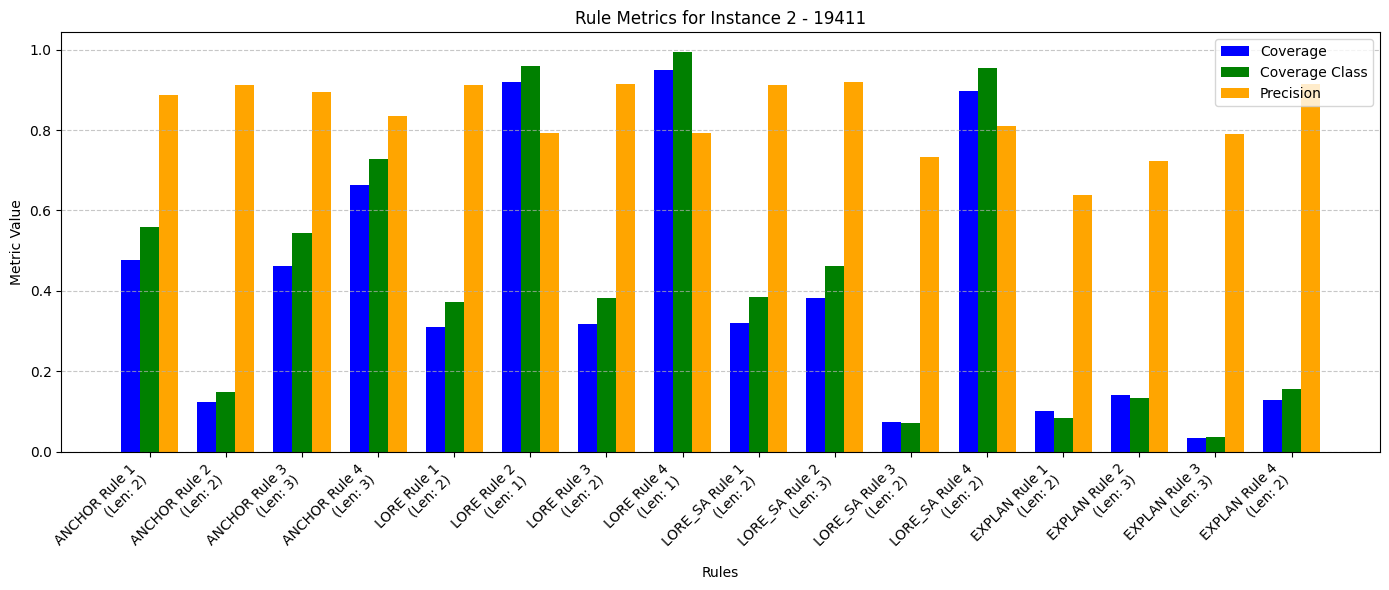

### All Rules Combined

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF age <= 37.0 AND capital.gain <= 0.0 THEN class = <=50K,0.47733,0.55831,0.88805,2
1,ANCHOR,ANCHOR Rule 2,IF capital.gain <= 0.0 AND marital.status = Divorced THEN class = <=50K,0.12417,0.14925,0.91261,2
2,ANCHOR,ANCHOR Rule 3,IF age <= 37.0 AND capital.gain <= 0.0 AND capital.loss <= 0.0 THEN class = <=50K,0.46064,0.54335,0.89556,3
3,ANCHOR,ANCHOR Rule 4,IF age <= 47.0 AND capital.gain <= 0.0 AND capital.loss <= 0.0 THEN class = <=50K,0.66220,0.72806,0.83475,3
4,LORE,LORE Rule 1,IF capital.gain <= 594.0 AND sex = Female THEN class = <=50K,0.31006,0.37293,0.91317,2
5,LORE,LORE Rule 2,IF capital.gain <= 0.0 THEN class = <=50K,0.91842,0.95820,0.79213,1
6,LORE,LORE Rule 3,IF capital.gain <= 4064.0 AND sex = Female THEN class = <=50K,0.31784,0.38250,0.91369,2
7,LORE,LORE Rule 4,IF capital.gain <= 4885.808886 THEN class = <=50K,0.95035,0.99339,0.79362,1
8,LORE_SA,LORE_SA Rule 1,IF capital.gain <= 5975.1396484375 AND sex = Female THEN class = <=50K,0.32102,0.38533,0.91135,2
9,LORE_SA,LORE_SA Rule 2,IF age <= 35.82083320617676 AND capital.gain <= 12236.846435546875 AND education != Bachelors THEN class = <=50K,0.38141,0.46205,0.91975,3


## Instance - 28260

,Property,Value
0,Original Outcome,<=50K
1,Predicted Outcome,<=50K
2,Prediction Status,Correct


,Feature,Value
0,age,58.0
9,capital.gain,0.0
10,capital.loss,0.0
2,education,HS-grad
3,education.num,9
11,hours.per.week,38.0
4,marital.status,Widowed
12,native.country,United-States
5,occupation,Sales
7,race,White


### Explanation Rules

#### ANCHOR

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF capital.gain <= 0.0 AND capital.loss <= 0.0 AND hours.per.week <= 40.0 AND native.country = United-States THEN class = <=50K,0.56956,0.64366,0.85802,4
1,ANCHOR,ANCHOR Rule 2,IF capital.loss <= 0.0 AND education = HS-grad THEN class = <=50K,0.31365,0.35095,0.84954,2
2,ANCHOR,ANCHOR Rule 3,IF capital.gain <= 0.0 AND capital.loss <= 0.0 AND hours.per.week <= 40.0 THEN class = <=50K,0.62883,0.71282,0.86065,3
3,ANCHOR,ANCHOR Rule 4,IF capital.gain <= 0.0 AND education.num = 9.0 THEN class = <=50K,0.30658,0.34650,0.85810,2


##### Formatted view for readability:

#### LORE

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE,LORE Rule 1,IF capital.gain <= 3791.128472 THEN class = <=50K,0.94186,0.98463,0.79372,1
1,LORE,LORE Rule 2,IF capital.gain <= 1600.445513 THEN class = <=50K,0.92210,0.96306,0.79296,1
2,LORE,LORE Rule 3,IF capital.gain <= 0.0 THEN class = <=50K,0.91842,0.95820,0.79213,1
3,LORE,LORE Rule 4,IF capital.gain <= 6849.0 AND workclass = Private THEN class = <=50K,0.73109,0.78967,0.82008,2


##### Formatted view for readability:

#### LORE_SA

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE_SA,LORE_SA Rule 1,IF capital.gain <= 9955.46484375 AND capital.loss <= 2497.816162109375 AND hours.per.week <= 68.97641372680664 THEN class = <=50K,0.95301,0.97762,0.77884,3
1,LORE_SA,LORE_SA Rule 2,IF capital.gain <= 7207.525146484375 AND education.num != 6 THEN class = <=50K,0.93008,0.96441,0.78726,2
2,LORE_SA,LORE_SA Rule 3,IF capital.gain <= 6924.942138671875 AND hours.per.week <= 41.503997802734375 AND native.country != Thailand AND native.country != Laos THEN class = <=50K,0.68328,0.76352,0.84839,4
3,LORE_SA,LORE_SA Rule 4,IF capital.gain <= 6077.3770751953125 AND marital.status != Married-civ-spouse AND workclass = Private THEN class = <=50K,0.42850,0.53971,0.95628,3


##### Formatted view for readability:

#### EXPLAN

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,EXPLAN,EXPLAN Rule 1,IF age > 49.88668 AND capital.gain <= 4842.551271 AND capital.loss <= 1876.673429 AND hours.per.week <= 45.034388 THEN class = <=50K,0.15457,0.15424,0.75762,4
1,EXPLAN,EXPLAN Rule 2,IF capital.gain <= 0.0 AND education.num = 9 AND relationship = Not-in-family THEN class = <=50K,0.07647,0.09748,0.96787,3
2,EXPLAN,EXPLAN Rule 3,IF age > 45.459129 AND capital.gain <= 0.0 AND capital.loss <= 147.879185 AND hours.per.week <= 45.0 THEN class = <=50K,0.19265,0.18849,0.74283,4
3,EXPLAN,EXPLAN Rule 4,IF capital.gain <= 0.0 AND education.num = 9 THEN class = <=50K,0.30658,0.34650,0.85810,2


##### Formatted view for readability:

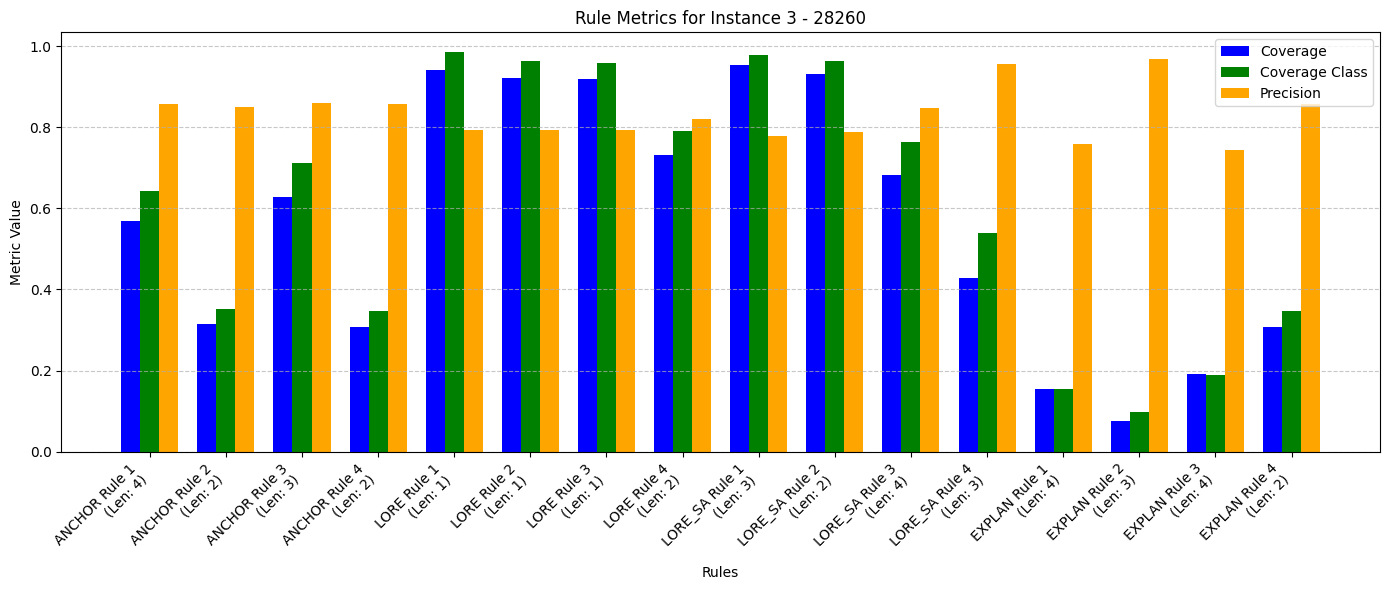

### All Rules Combined

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF capital.gain <= 0.0 AND capital.loss <= 0.0 AND hours.per.week <= 40.0 AND native.country = United-States THEN class = <=50K,0.56956,0.64366,0.85802,4
1,ANCHOR,ANCHOR Rule 2,IF capital.loss <= 0.0 AND education = HS-grad THEN class = <=50K,0.31365,0.35095,0.84954,2
2,ANCHOR,ANCHOR Rule 3,IF capital.gain <= 0.0 AND capital.loss <= 0.0 AND hours.per.week <= 40.0 THEN class = <=50K,0.62883,0.71282,0.86065,3
3,ANCHOR,ANCHOR Rule 4,IF capital.gain <= 0.0 AND education.num = 9.0 THEN class = <=50K,0.30658,0.34650,0.85810,2
4,LORE,LORE Rule 1,IF capital.gain <= 3791.128472 THEN class = <=50K,0.94186,0.98463,0.79372,1
5,LORE,LORE Rule 2,IF capital.gain <= 1600.445513 THEN class = <=50K,0.92210,0.96306,0.79296,1
6,LORE,LORE Rule 3,IF capital.gain <= 0.0 THEN class = <=50K,0.91842,0.95820,0.79213,1
7,LORE,LORE Rule 4,IF capital.gain <= 6849.0 AND workclass = Private THEN class = <=50K,0.73109,0.78967,0.82008,2
8,LORE_SA,LORE_SA Rule 1,IF capital.gain <= 9955.46484375 AND capital.loss <= 2497.816162109375 AND hours.per.week <= 68.97641372680664 THEN class = <=50K,0.95301,0.97762,0.77884,3
9,LORE_SA,LORE_SA Rule 2,IF capital.gain <= 7207.525146484375 AND education.num != 6 THEN class = <=50K,0.93008,0.96441,0.78726,2


## Instance - 17800

,Property,Value
0,Original Outcome,>50K
1,Predicted Outcome,>50K
2,Prediction Status,Correct


,Feature,Value
0,age,40.0
9,capital.gain,0.0
10,capital.loss,0.0
2,education,Bachelors
3,education.num,13
11,hours.per.week,40.0
4,marital.status,Married-civ-spouse
12,native.country,United-States
5,occupation,Prof-specialty
7,race,White


### Explanation Rules

#### ANCHOR

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty AND race = White THEN class = >50K,0.01894,0.05187,0.65946,7
1,ANCHOR,ANCHOR Rule 2,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND occupation = Prof-specialty AND relationship = Wife THEN class = >50K,0.00348,0.01020,0.70588,5
2,ANCHOR,ANCHOR Rule 3,IF age > 37.0 AND capital.gain <= 0.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty THEN class = >50K,0.01228,0.03104,0.60833,7
3,ANCHOR,ANCHOR Rule 4,IF age > 28.0 AND capital.gain <= 0.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty AND race = White THEN class = >50K,0.01587,0.04039,0.61290,8


##### Formatted view for readability:

#### LORE

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE,LORE Rule 1,IF age > 39.46657 AND age <= 41.0 THEN class = <=50K,0.05047,0.04355,0.65517,2
1,LORE,LORE Rule 2,IF marital.status = Married-civ-spouse AND occupation = Prof-specialty AND relationship = Wife AND sex = Female THEN class = >50K,0.01413,0.03529,0.60145,4
2,LORE,LORE Rule 3,IF hours.per.week > 14.0 AND marital.status = Married-civ-spouse AND occupation = Prof-specialty AND relationship = Wife AND sex = Female THEN class = >50K,0.01228,0.03104,0.60833,5
3,LORE,LORE Rule 4,IF age > 39.0 AND age <= 40.0 THEN class = <=50K,0.02487,0.02157,0.65844,2


##### Formatted view for readability:

#### LORE_SA

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE_SA,LORE_SA Rule 1,IF education != 10th AND marital.status = Married-civ-spouse AND native.country != Japan AND native.country != Hungary AND occupation = Prof-specialty AND race != Asian-Pac-Islander AND relationship = Wife AND sex != Male THEN class = >50K,0.01341,0.03444,0.61832,8
1,LORE_SA,LORE_SA Rule 2,IF education.num != 5 AND hours.per.week > 17.53827142715454 AND marital.status = Married-civ-spouse AND native.country != South AND native.country != Ireland AND occupation != Other-service AND occupation != Handlers-cleaners AND occupation != Machine-op-inspct AND occupation != Craft-repair AND race != Other AND relationship = Wife AND sex = Female THEN class = >50K,0.03501,0.07908,0.54386,12
2,LORE_SA,LORE_SA Rule 3,IF education = Bachelors AND education.num != 6 AND hours.per.week <= 85.9917984008789 AND marital.status = Married-civ-spouse AND occupation != Other-service AND occupation != Craft-repair AND occupation != Protective-serv AND race = White AND relationship = Wife AND sex != Male THEN class = >50K,0.00798,0.02338,0.70513,10
3,LORE_SA,LORE_SA Rule 4,IF education != 9th AND education != 11th AND education != 5th-6th AND hours.per.week > 6.4074931144714355 AND marital.status = Married-civ-spouse AND native.country != Puerto-Rico AND occupation = Prof-specialty AND relationship = Wife AND sex != Male THEN class = >50K,0.01280,0.03359,0.63200,9


##### Formatted view for readability:

#### EXPLAN

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,EXPLAN,EXPLAN Rule 1,IF age > 39.334078 AND capital.gain <= 0.0 AND marital.status = Married-civ-spouse AND relationship = Wife AND sex = Female THEN class = >50K,0.02017,0.04209,0.50254,5
1,EXPLAN,EXPLAN Rule 2,IF capital.gain <= 3407.807261 AND education = Bachelors AND hours.per.week <= 43.207671 AND marital.status = Married-civ-spouse AND relationship = Wife AND sex = Female THEN class = >50K,0.00614,0.01616,0.63333,6
2,EXPLAN,EXPLAN Rule 3,IF capital.gain <= 0.0 AND education = Bachelors AND relationship = Wife THEN class = >50K,0.00788,0.02041,0.62338,3
3,EXPLAN,EXPLAN Rule 4,IF capital.gain <= 7015.828777 AND marital.status = Married-civ-spouse AND relationship = Wife THEN class = >50K,0.04320,0.07738,0.43128,3


##### Formatted view for readability:

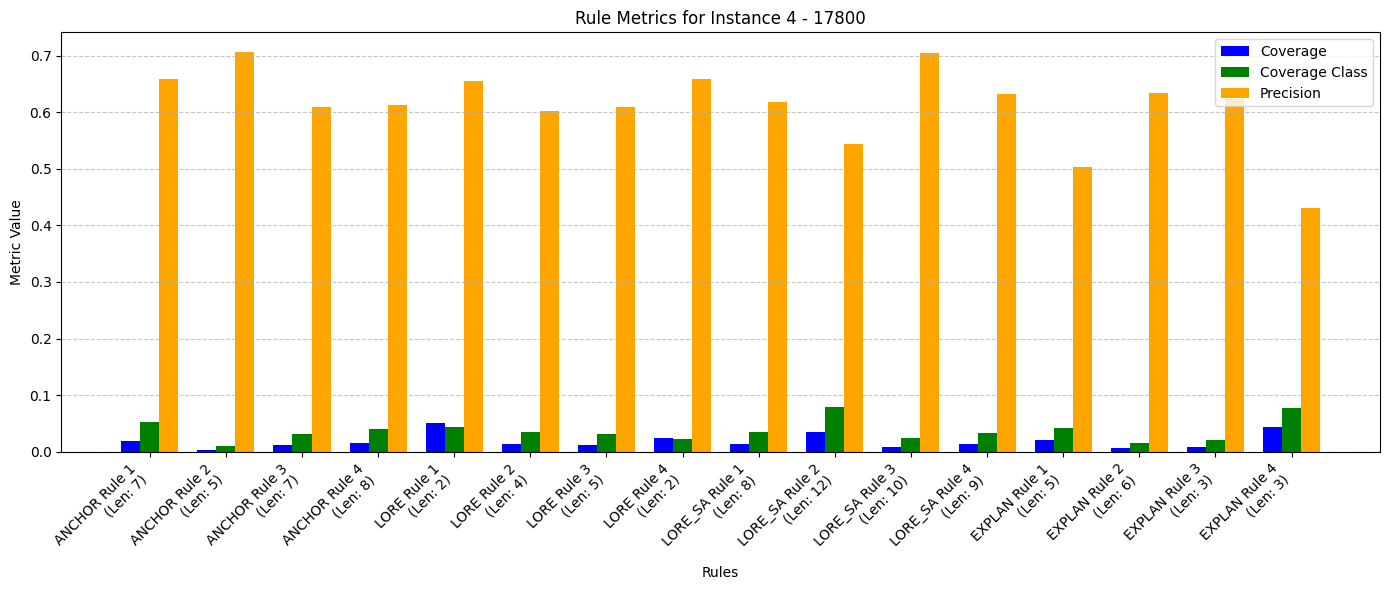

### All Rules Combined

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty AND race = White THEN class = >50K,0.01894,0.05187,0.65946,7
1,ANCHOR,ANCHOR Rule 2,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND occupation = Prof-specialty AND relationship = Wife THEN class = >50K,0.00348,0.01020,0.70588,5
2,ANCHOR,ANCHOR Rule 3,IF age > 37.0 AND capital.gain <= 0.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty THEN class = >50K,0.01228,0.03104,0.60833,7
3,ANCHOR,ANCHOR Rule 4,IF age > 28.0 AND capital.gain <= 0.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Prof-specialty AND race = White THEN class = >50K,0.01587,0.04039,0.61290,8
4,LORE,LORE Rule 1,IF age > 39.46657 AND age <= 41.0 THEN class = <=50K,0.05047,0.04355,0.65517,2
5,LORE,LORE Rule 2,IF marital.status = Married-civ-spouse AND occupation = Prof-specialty AND relationship = Wife AND sex = Female THEN class = >50K,0.01413,0.03529,0.60145,4
6,LORE,LORE Rule 3,IF hours.per.week > 14.0 AND marital.status = Married-civ-spouse AND occupation = Prof-specialty AND relationship = Wife AND sex = Female THEN class = >50K,0.01228,0.03104,0.60833,5
7,LORE,LORE Rule 4,IF age > 39.0 AND age <= 40.0 THEN class = <=50K,0.02487,0.02157,0.65844,2
8,LORE_SA,LORE_SA Rule 1,IF education != 10th AND marital.status = Married-civ-spouse AND native.country != Japan AND native.country != Hungary AND occupation = Prof-specialty AND race != Asian-Pac-Islander AND relationship = Wife AND sex != Male THEN class = >50K,0.01341,0.03444,0.61832,8
9,LORE_SA,LORE_SA Rule 2,IF education.num != 5 AND hours.per.week > 17.53827142715454 AND marital.status = Married-civ-spouse AND native.country != South AND native.country != Ireland AND occupation != Other-service AND occupation != Handlers-cleaners AND occupation != Machine-op-inspct AND occupation != Craft-repair AND race != Other AND relationship = Wife AND sex = Female THEN class = >50K,0.03501,0.07908,0.54386,12


## Instance - 19215

,Property,Value
0,Original Outcome,>50K
1,Predicted Outcome,>50K
2,Prediction Status,Correct


,Feature,Value
0,age,41.0
9,capital.gain,0.0
10,capital.loss,0.0
2,education,Bachelors
3,education.num,13
11,hours.per.week,50.0
4,marital.status,Married-civ-spouse
12,native.country,United-States
5,occupation,Exec-managerial
7,race,White


### Explanation Rules

#### ANCHOR

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF education = Bachelors AND education.num = 13.0 AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.02498,0.08121,0.78279,4
1,ANCHOR,ANCHOR Rule 2,IF age > 37.0 AND education = Bachelors AND education.num = 13.0 AND hours.per.week > 40.0 AND marital.status = Married-civ-spouse THEN class = >50K,0.02651,0.07951,0.72201,5
2,ANCHOR,ANCHOR Rule 3,IF education = Bachelors AND hours.per.week > 40.0 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial THEN class = >50K,0.01505,0.04847,0.77551,4
3,ANCHOR,ANCHOR Rule 4,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Exec-managerial AND race = White AND relationship = Husband AND sex = Male THEN class = >50K,0.02068,0.06803,0.79208,9


##### Formatted view for readability:

#### LORE

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE,LORE Rule 1,IF age > 27.0 AND hours.per.week > 45.0 AND relationship = Husband THEN class = >50K,0.12038,0.28274,0.56548,3
1,LORE,LORE Rule 2,IF age > 26.0 AND hours.per.week > 35.0 AND marital.status = Married-civ-spouse AND relationship = Husband THEN class = >50K,0.34712,0.69855,0.48452,4
2,LORE,LORE Rule 3,IF age > 28.0 AND hours.per.week > 27.185546 AND marital.status = Married-civ-spouse AND relationship = Husband THEN class = >50K,0.34906,0.70451,0.48592,4
3,LORE,LORE Rule 4,IF age > 26.0 AND hours.per.week > 40.0 THEN class = >50K,0.26727,0.47959,0.43202,2


##### Formatted view for readability:

#### LORE_SA

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,LORE_SA,LORE_SA Rule 1,IF education != 11th AND education.num != 6 AND hours.per.week > 39.68734073638916 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.06285,0.18325,0.70195,6
1,LORE_SA,LORE_SA Rule 2,IF age > 27.8580379486084 AND education.num != 4 AND hours.per.week > 24.549214363098145 AND marital.status != Never-married AND marital.status != Separated AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.06377,0.18580,0.70144,7
2,LORE_SA,LORE_SA Rule 3,IF age <= 85.74833679199219 AND age > 25.57025909423828 AND education != HS-grad AND hours.per.week > 37.49129867553711 AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.05221,0.16327,0.75294,6
3,LORE_SA,LORE_SA Rule 4,IF age <= 81.11835861206055 AND education.num != 4 AND hours.per.week > 23.454591751098633 AND marital.status = Married-civ-spouse AND native.country != Mexico AND occupation = Exec-managerial AND race != Other AND relationship = Husband THEN class = >50K,0.06551,0.18920,0.69531,8


##### Formatted view for readability:

#### EXPLAN

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,EXPLAN,EXPLAN Rule 1,IF capital.gain <= 4556.061093 AND capital.loss <= 653.0 AND hours.per.week > 48.866171 AND marital.status = Married-civ-spouse AND relationship = Husband THEN class = >50K,0.09387,0.18367,0.47110,5
1,EXPLAN,EXPLAN Rule 2,IF capital.gain <= 0.0 AND education = Bachelors AND marital.status = Married-civ-spouse AND occupation = Exec-managerial AND relationship = Husband AND sex = Male THEN class = >50K,0.01976,0.05995,0.73057,6
2,EXPLAN,EXPLAN Rule 3,IF capital.gain <= 4881.663471 AND hours.per.week > 43.708183 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.03122,0.08631,0.66557,5
3,EXPLAN,EXPLAN Rule 4,IF capital.gain <= 5086.901545 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.05896,0.15434,0.63021,4


##### Formatted view for readability:

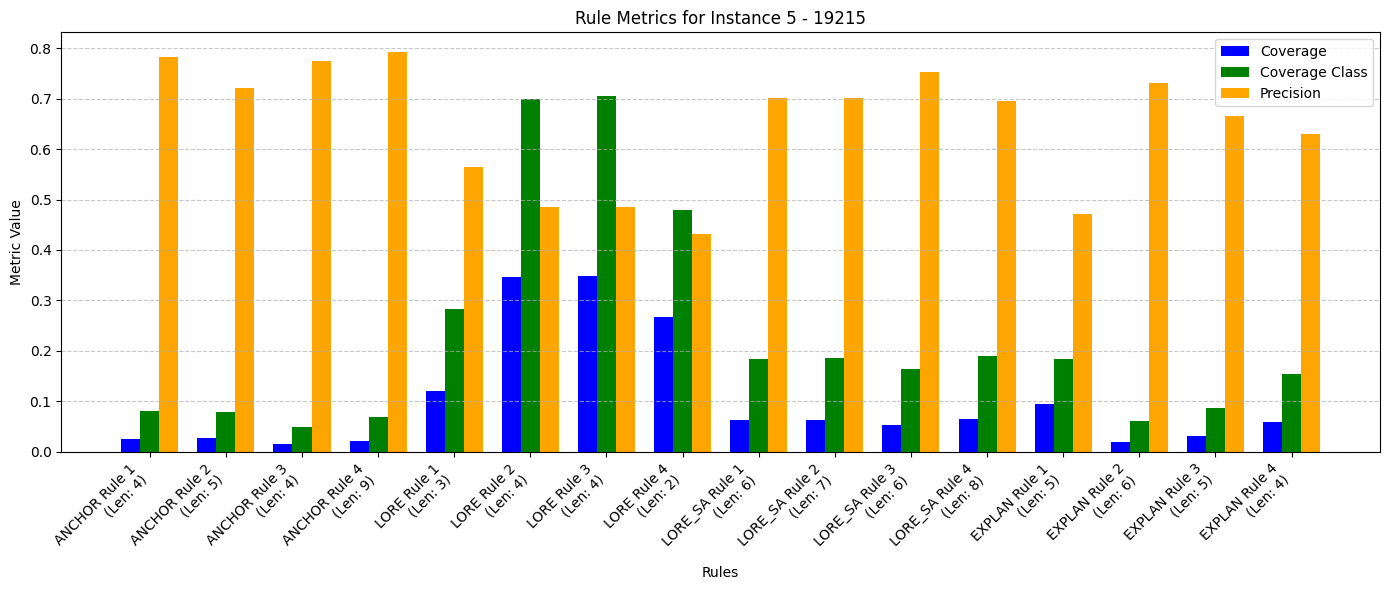

### All Rules Combined

,Explainer,Rule,Text,Coverage (Cov),Coverage Class (Cov_class),Precision (Pre),Length (Len)
0,ANCHOR,ANCHOR Rule 1,IF education = Bachelors AND education.num = 13.0 AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.02498,0.08121,0.78279,4
1,ANCHOR,ANCHOR Rule 2,IF age > 37.0 AND education = Bachelors AND education.num = 13.0 AND hours.per.week > 40.0 AND marital.status = Married-civ-spouse THEN class = >50K,0.02651,0.07951,0.72201,5
2,ANCHOR,ANCHOR Rule 3,IF education = Bachelors AND hours.per.week > 40.0 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial THEN class = >50K,0.01505,0.04847,0.77551,4
3,ANCHOR,ANCHOR Rule 4,IF age > 28.0 AND education = Bachelors AND education.num = 13.0 AND marital.status = Married-civ-spouse AND native.country = United-States AND occupation = Exec-managerial AND race = White AND relationship = Husband AND sex = Male THEN class = >50K,0.02068,0.06803,0.79208,9
4,LORE,LORE Rule 1,IF age > 27.0 AND hours.per.week > 45.0 AND relationship = Husband THEN class = >50K,0.12038,0.28274,0.56548,3
5,LORE,LORE Rule 2,IF age > 26.0 AND hours.per.week > 35.0 AND marital.status = Married-civ-spouse AND relationship = Husband THEN class = >50K,0.34712,0.69855,0.48452,4
6,LORE,LORE Rule 3,IF age > 28.0 AND hours.per.week > 27.185546 AND marital.status = Married-civ-spouse AND relationship = Husband THEN class = >50K,0.34906,0.70451,0.48592,4
7,LORE,LORE Rule 4,IF age > 26.0 AND hours.per.week > 40.0 THEN class = >50K,0.26727,0.47959,0.43202,2
8,LORE_SA,LORE_SA Rule 1,IF education != 11th AND education.num != 6 AND hours.per.week > 39.68734073638916 AND marital.status = Married-civ-spouse AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.06285,0.18325,0.70195,6
9,LORE_SA,LORE_SA Rule 2,IF age > 27.8580379486084 AND education.num != 4 AND hours.per.week > 24.549214363098145 AND marital.status != Never-married AND marital.status != Separated AND occupation = Exec-managerial AND relationship = Husband THEN class = >50K,0.06377,0.18580,0.70144,7


## Explainer Comparison

,Explainer,Avg Precision,Avg Coverage,Avg Coverage Class,Avg Length
0,ANCHOR,0.788515,0.230047,0.277726,4.3750
1,LORE,0.693927,0.449732,0.543714,2.3125
2,LORE_SA,0.755986,0.311367,0.375768,5.4375
3,EXPLAN,0.692456,0.088526,0.114797,3.7500


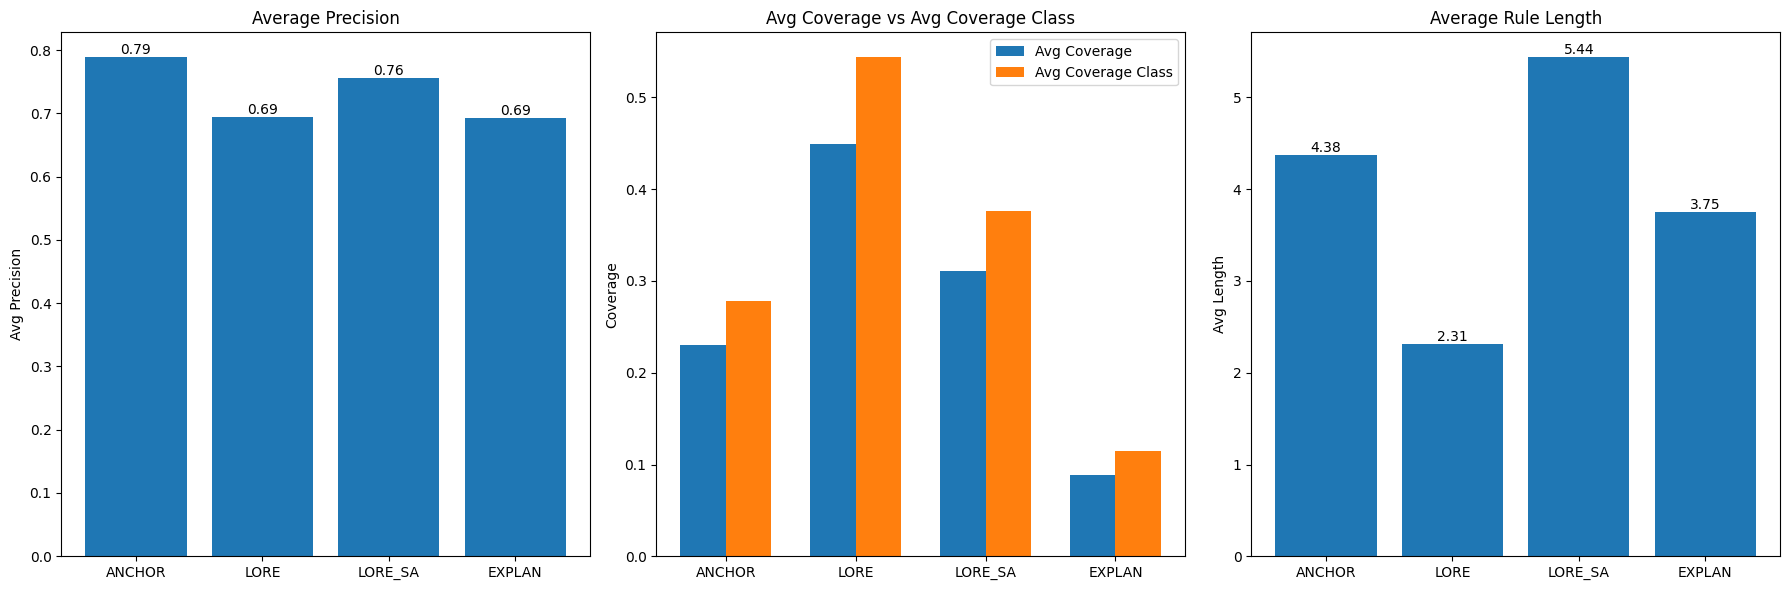

## Feature Usage Analysis

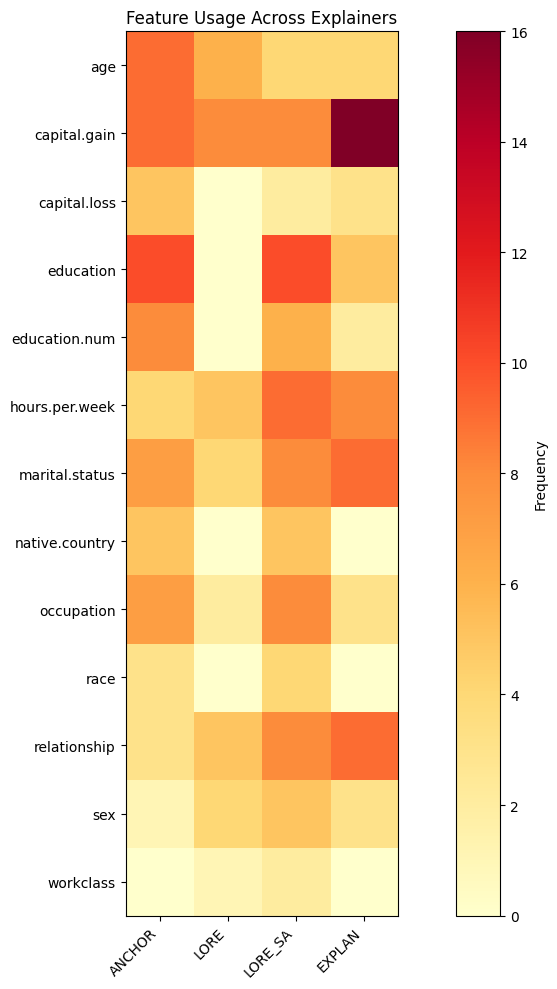

### Top Features Used by Each Explainer

#### ANCHOR

,Feature,Occurrence Count
0,education,10
1,age,9
2,capital.gain,9
3,education.num,8
4,marital.status,7


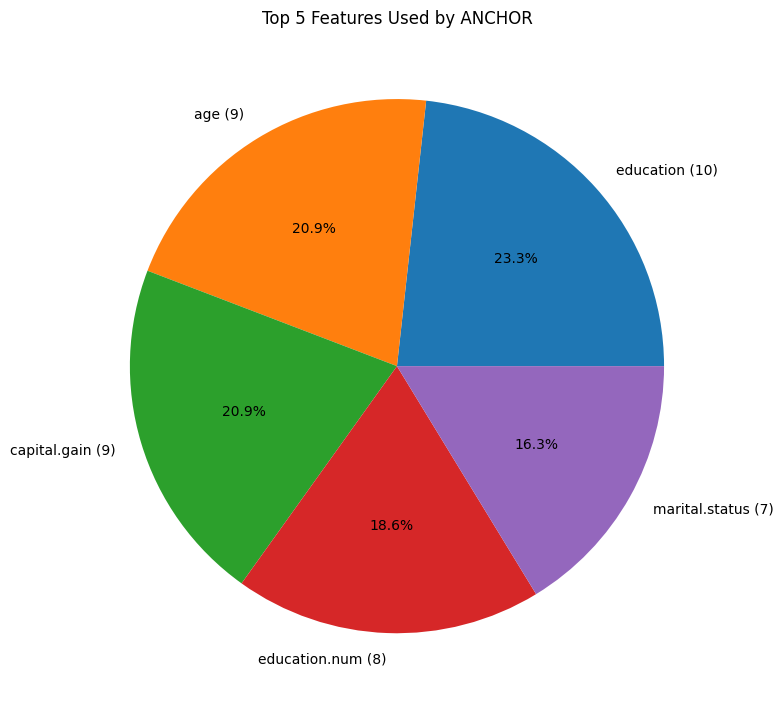

#### LORE

,Feature,Occurrence Count
0,capital.gain,8
1,age,6
2,relationship,5
3,hours.per.week,5
4,sex,4


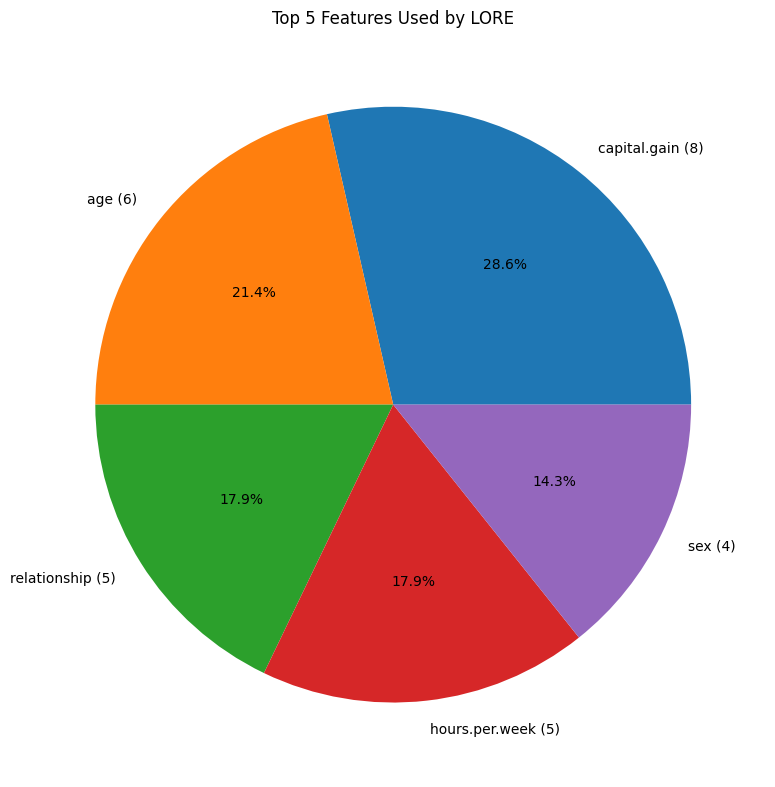

#### LORE_SA

,Feature,Occurrence Count
0,education,10
1,hours.per.week,9
2,capital.gain,8
3,marital.status,8
4,relationship,8


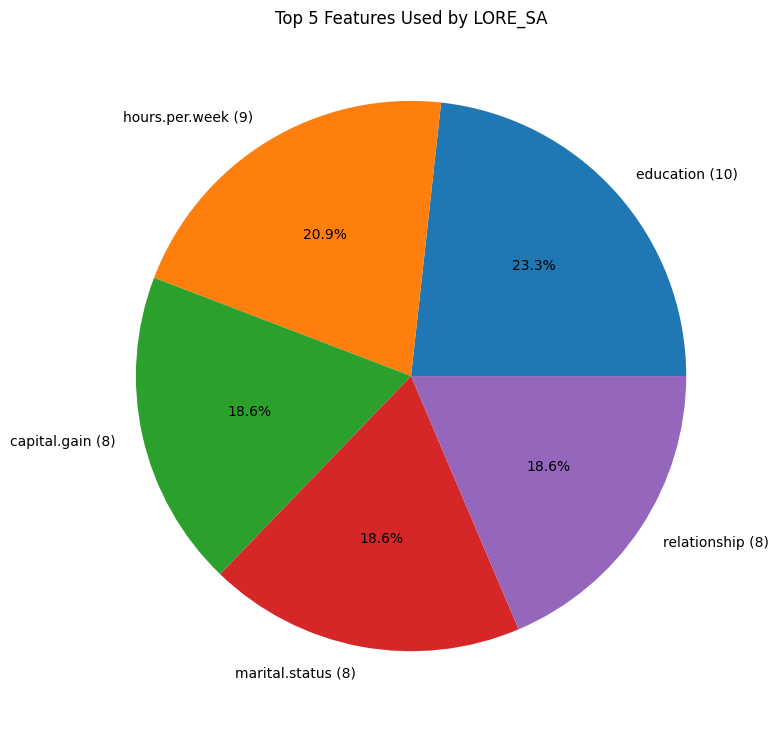

#### EXPLAN

,Feature,Occurrence Count
0,capital.gain,16
1,marital.status,9
2,relationship,9
3,hours.per.week,8
4,education,5


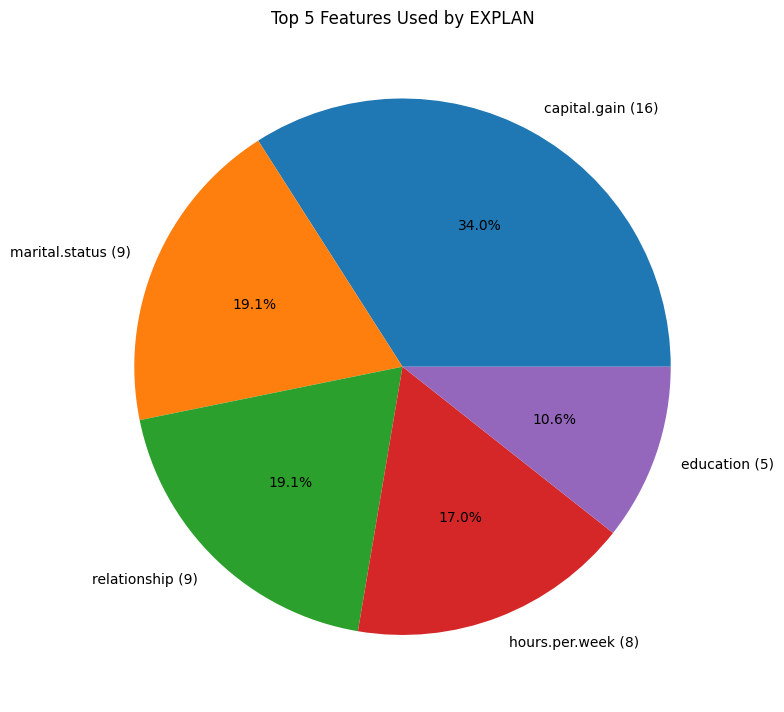

## Analysis by Outcome

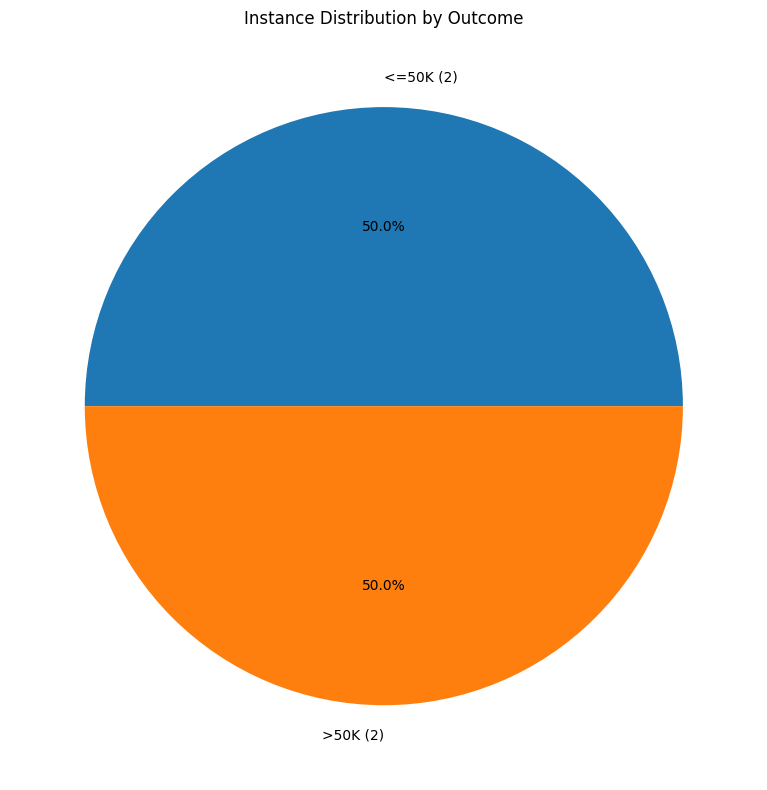

### Outcome: <=50K

,Rule Count,Avg Precision,Avg Coverage,Avg Coverage Class,Avg Length
ANCHOR,8,0.869660,0.442870,0.504112,2.625
LORE,8,0.826437,0.751268,0.800322,1.375
LORE_SA,8,0.843102,0.583541,0.640035,2.625
EXPLAN,8,0.798914,0.141903,0.149555,2.875


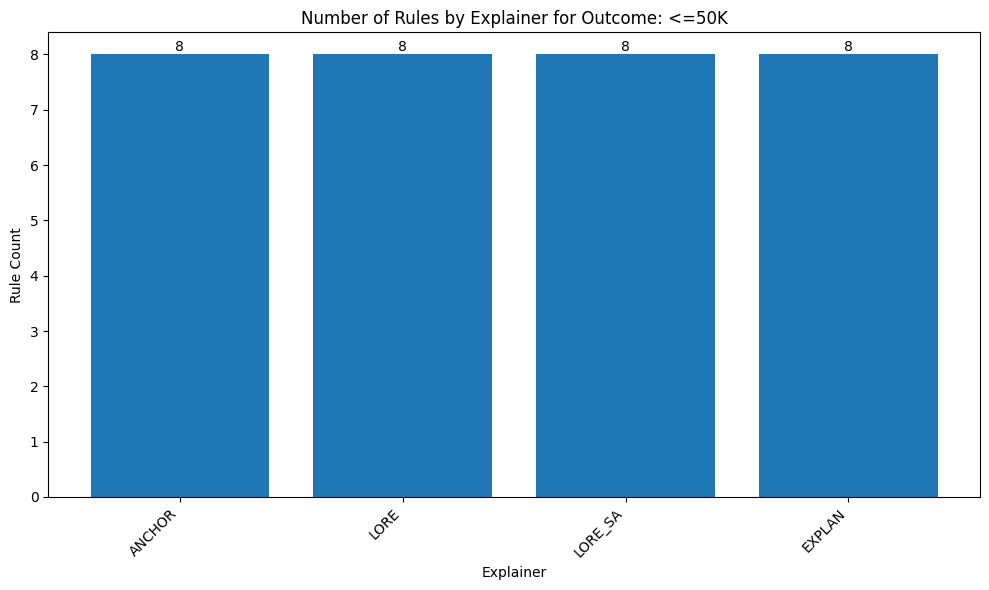

### Outcome: >50K

,Rule Count,Avg Precision,Avg Coverage,Avg Coverage Class,Avg Length
ANCHOR,8,0.707370,0.017224,0.051340,6.125
LORE,8,0.561416,0.148197,0.287105,3.250
LORE_SA,8,0.668869,0.039192,0.111501,8.250
EXPLAN,8,0.585997,0.035150,0.080039,4.625


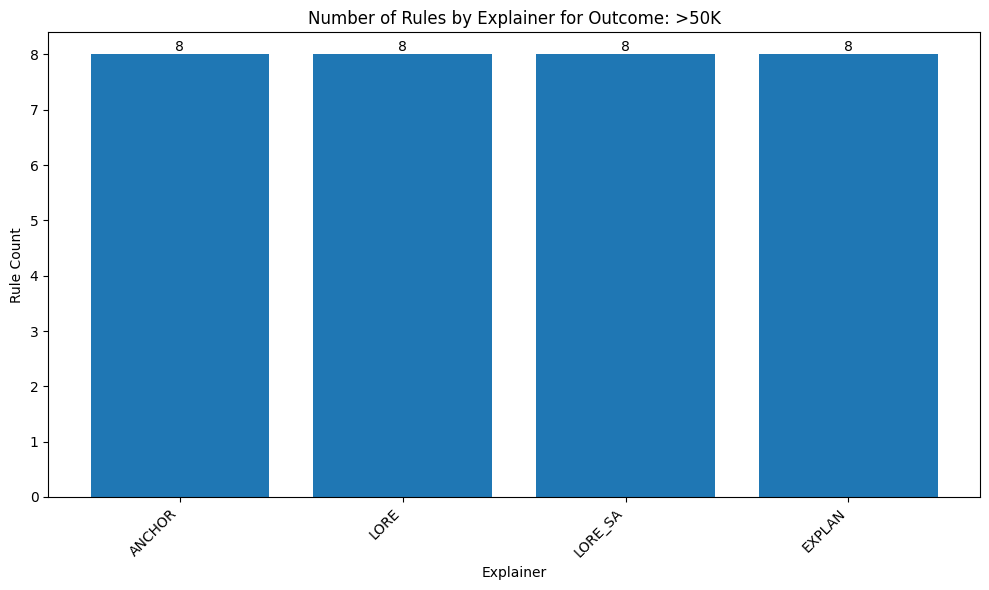

[{'features': {'age': '35.0',
   'workclass': 'Self-emp-not-inc',
   'education': '11th',
   'education.num': '7',
   'marital.status': 'Divorced',
   'occupation': 'Exec-managerial',
   'relationship': 'Unmarried',
   'race': 'White',
   'sex': 'Female',
   'capital.gain': '0.0',
   'capital.loss': '0.0',
   'hours.per.week': '84.0',
   'native.country': 'United-States'},
  'entry_name': '19411',
  'original_outcome': '<=50K',
  'predicted_outcome': '<=50K',
  'rules': {'ANCHOR': [{'text': 'IF age <= 37.0 AND capital.gain <= 0.0 THEN class = <=50K',
     'precision': 0.88805,
     'coverage': 0.47733,
     'coverage_class': 0.55831,
     'coverage_temp': 0.62869,
     'length': 2},
    {'text': 'IF capital.gain <= 0.0 AND marital.status = Divorced THEN class = <=50K',
     'precision': 0.91261,
     'coverage': 0.12417,
     'coverage_class': 0.14925,
     'coverage_temp': 0.16354,
     'length': 2},
    {'text': 'IF age <= 37.0 AND capital.gain <= 0.0 AND capital.loss <= 0.0 THEN cla

In [45]:
run_analysis_with_file("./experiments_log/adult_random_forest_13-12_20-05-2025.txt")